In [1]:
from random import seed
from random import randrange
from random import random
from math import log
from math import exp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
from numpy import mean

In [2]:
 #Load a iris dataset CSV file obtained from kaggle
def loadCsv(filename):
     trainSet = []
     data_frame = pd.read_csv(filename)
     data_frame['diagnosis'] = data_frame['diagnosis'].map({'B':0,'M':1,})
     temp = data_frame['diagnosis']
     data_frame = data_frame.drop(columns=['id','Unnamed: 32','diagnosis'],axis=1) #dropping  columns
     data_frame.insert(30,'diagnosis',temp)
     trainSet = data_frame.values.tolist()
     return trainSet 

In [3]:
# Find the min and max values for each column
def minmax(dataset):
        minmax = list()
        stats = [[min(column), max(column)] for column in zip(*dataset)]
        return stats
 
# Rescale dataset columns to the range 0-1
def normalize(dataset, minmax):
        for row in dataset:
                for i in range(len(row)-1):
                        row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [4]:
# Convert string column to integer
def column_to_int(dataset, column):
        class_values = [row[column] for row in dataset]
        unique = set(class_values)
        lookup = dict()
        for i, value in enumerate(unique):
                lookup[value] = i
        for row in dataset:
                row[column] = lookup[row[column]]
        return lookup

In [5]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
        dataset_split = list()
        dataset_copy = list(dataset)
        fold_size = int(len(dataset) / n_folds)
        for i in range(n_folds):
                fold = list()
                while len(fold) < fold_size:
                        index = randrange(len(dataset_copy))
                        fold.append(dataset_copy.pop(index))
                dataset_split.append(fold)
        return dataset_split
 
# Calculate accuracy percentage
def accuracy_met(actual, predicted):
        correct = 0
        for i in range(len(actual)):
                if actual[i] == predicted[i]:
                        correct += 1
        return correct / float(len(actual)) * 100.0

In [6]:
# Evaluate an algorithm using a cross validation split
def run_algorithm(dataset, algorithm, n_folds, *args):
        
        folds = cross_validation_split(dataset, n_folds)
        #for fold in folds:
                #print("Fold {} \n \n".format(fold))
        test_scores = list()
        train_scores = list()
        train_losses=list()
        test_losses= list()
        f1_scores = list()
        k_scores = list()
        for fold in folds:
                #print("Test Fold {} \n \n".format(fold))
                train_set = list(folds)
                train_set.remove(fold)
                train_set = sum(train_set, [])
                test_set = list()
                for row in fold:
                        row_copy = list(row)
                        test_set.append(row_copy)
                        row_copy[-1] = None
                test_actual = [row[-1] for row in fold]
                train_actual= [row[-1] for row in train_set]
                test_predicted,train_predicted,epochs,ep_loss,k0 = algorithm(train_set, test_set,test_actual, *args)             
                test_accuracy = accuracy_met(test_actual, test_predicted)
                train_accuracy = accuracy_met(train_actual, train_predicted)
                #one-hot encoding actual train and test data.
                test_actual_ohe = ohe_encoding(test_actual)
                train_actual_ohe = ohe_encoding(train_actual)
                test_predicted_ohe = ohe_encoding(test_predicted)
                train_predicted_ohe = ohe_encoding(train_predicted)
                test_loss = categorical_cross_entropy(test_actual_ohe, test_predicted_ohe)
                train_loss= categorical_cross_entropy(train_actual_ohe, train_predicted_ohe)
                f1_score, k_score = cal_f1_k_scores(test_actual, test_predicted)
                train_scores.append(train_accuracy)
                test_scores.append(test_accuracy)
                test_losses.append(test_loss)
                train_losses.append(train_loss)
                f1_scores.append(f1_score)
                k_scores.append(k_score)
        return train_scores,test_scores,train_losses,test_losses,f1_scores,k_scores,epochs,ep_loss,k0

In [7]:
#binary enocoding:
def ohe_encoding(actual):
    ohe_res = list()
    for a in actual:
      if (a==0): 
          ohe_res.append([1,0]) #Class0 {1,0}
      elif (a==1):
          ohe_res.append([0,1]) #Class1 {0,1}
    return ohe_res 

In [8]:
# calculating categorical cross entropy
def categorical_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		for j in range(len(actual[i])):
			sum_score += actual[i][j] * log(1e-15 + predicted[i][j])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score

In [9]:
#calculating f1_score and k_score
def cal_f1_k_scores(actual, predicted):
   cm = confusion_matrix(actual, predicted)
   FP = cm.sum(axis=0) - np.diag(cm)
   FN = cm.sum(axis=1) - np.diag(cm)
   TP = np.diag(cm)
   TN = cm.sum() - (FP + FN + TP)
   TPR = TP/(TP+FN)
   TNR = TN/(TN+FP)
   Precision = TP/(TP+FP)
   Recall = TP/(TP+FN)
   Acc = (TP+TN)/(TP+TN+FP+FN)
   Fscore = 2*(Precision*Recall)/(Precision+Recall)
   k=cohen_kappa_score(actual, predicted)
   return Fscore,k

In [10]:
# Calculate neuron activation for an input
def activate(weights, inputs):
        activation = weights[-1]
        for i in range(len(weights)-1):
                activation += weights[i] * inputs[i]
        return activation

In [11]:
# Transfer neuron sigmoid activation function
def transfer(activation,activation_function):
       if activation_function == "sigmoid":
            return 1.0 / (1.0 + exp(-activation))
       elif activation_function == "tanh":
            return np.tanh(activation)
       elif activation_function == "relu":
            return np.maximum(0,activation)
       elif activation_function == "leaky_relu":
            return np.maximum(0.01*activation,activation)

In [12]:
# Calculate the derivative of an neuron output
def transfer_derivative(output,activation_function):
        if activation_function == "sigmoid":
            return output * (1.0 - output)
        elif activation_function == "tanh":
             return (1-output**2)
        elif activation_function == "relu":
             return 1.0*(output>0)
        elif activation_function == "leaky_relu":
             if output>0:
               return 1.0
             else:
               return 0.01

In [13]:
# Forward propagate input to a network output
def forward_propagate(network, row,af):
        inputs = row
        #hidden layer
        layer = network[0]  
        new_inputs = []                     
        for neuron in layer:
              activation = activate(neuron['weights'], inputs)
              neuron['output'] = transfer(activation,af)
              new_inputs.append(neuron['output'])
        inputs = new_inputs
        #output layer
        layer = network[1]
        new_inputs = []        
        for neuron in layer:
              activation = activate(neuron['weights'], inputs)
              neuron['output'] = transfer(activation,'sigmoid')
              new_inputs.append(neuron['output'])
        inputs = new_inputs
        return inputs

In [14]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected,af):
        for i in reversed(range(len(network))):
                layer = network[i]
                errors = list()
                if i != len(network)-1:
                        for j in range(len(layer)):
                                error = 0.0
                                for neuron in network[i + 1]:
                                        error += (neuron['weights'][j] * neuron['delta'])
                                errors.append(error)
                        for j in range(len(layer)):
                              neuron = layer[j]
                              neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],af)
                else:
                        for j in range(len(layer)):
                                neuron = layer[j]
                                errors.append(expected[j] - neuron['output'])
                        for j in range(len(layer)):
                              neuron = layer[j]
                              neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],'sigmoid')

In [15]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			 for j in range(len(inputs)):
				  neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			 neuron['weights'][-1] += l_rate * neuron['delta']

In [16]:
# # Train a network for a fixed number of epochs
def train_network(network, train,test,test_actual, l_rate, n_epoch, n_outputs,af):
        epochs=list()
        k0 = list()
        ep_loss = list() #test loss at the end of each epoch
        for epoch in range(n_epoch):
                for row in train:
                        outputs = forward_propagate(network, row,af)
                        #print(network)
                        expected = [0 for i in range(n_outputs)]
                        expected[row[-1]] = 1                  
                        backward_propagate_error(network, expected,af)
                        update_weights(network, row, l_rate)
                if ((epoch % 50 == 0)or(epoch == 1)):
                       epochs.append(epoch)                  
                       loss = epoch_vs_loss(network,train,test,test_actual)
                       ep_loss.append(loss)
                       for layer in network:
                          bias = list()
                          for neuron in layer:
                             bias.append(neuron['weights'][-1])
                          k0.append(bias)                
        return epochs,ep_loss,k0

In [17]:
#predicting loss vs epoch
def epoch_vs_loss(network,train,test,test_actual):
      test_predictions,train_predictions = train_test_prediction(network,train,test)
      test_predicted_ohe = ohe_encoding(test_predictions)
      test_temp_ohe = ohe_encoding(test_actual)              
      test_loss = categorical_cross_entropy(test_temp_ohe, test_predicted_ohe)
      return test_loss

In [18]:
#selecting weights as per the activation function
#refernce :
def weights_init(name,n,m):
       if name == 'tanh':
            res = random()
       elif name == 'relu':
           res = he_normal(n)
       elif name == 'leaky_relu':
           res = he_normal(n)
       elif name  == 'sigmoid':
            res = xavier_glorot(n,m)
       return res
      
def xavier_glorot(n,m):    
  # number of nodes in the previous layer is n
  # number of nodes in the next layer is m
  # calculate the range for the weights
  lower, upper = -(sqrt(6.0) / sqrt(n + m)), (sqrt(6.0) / sqrt(n + m))
  # generate random numbers
  numbers = random()
  # scale to the desired range
  scaled = lower + numbers * (upper - lower)
  return scaled

def he_normal(n):
  # number of nodes in the previous layer is n
  # calculate the range for the weights
  std = sqrt(2.0 / n)
  # generate random numbers
  numbers = random()
  # scale to the desired range
  scaled = numbers * std
  return scaled

In [19]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs,af):
	      network = list()
	      hidden_layer = [{'weights':[weights_init(af,n_inputs,n_outputs) for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	      network.append(hidden_layer)
	      output_layer = [{'weights':[weights_init(af,n_hidden,1) for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	      network.append(output_layer)
	      return network

In [20]:
# Make a prediction with a network
def predict(network, row):
        outputs = forward_propagate(network, row,af)
        return outputs.index(max(outputs))
        
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, test_actual, l_rate, n_epoch, n_hidden,af):
        n_inputs = len(train[0]) - 1
        n_outputs = len(set([row[-1] for row in train]))
        network = initialize_network(n_inputs, n_hidden, n_outputs,af)
        epochs,ep_loss,k0 = train_network(network, train,test, test_actual,l_rate, n_epoch, n_outputs,af)
        test_predictions,train_predictions = train_test_prediction(network,train,test)
        print("The weights, biases and output values at the end of training each fold")
        print(network)
        return test_predictions,train_predictions,epochs,ep_loss,k0

In [21]:
#predicting on train and test data
def train_test_prediction(network,train,test):
  train_predictions = list()
  test_predictions = list()
  #predicting test values
  for row in test:
          test_prediction = predict(network, row)
          test_predictions.append(test_prediction)
  #predicting train values
  for row in train:
          train_prediction = predict(network, row)
          train_predictions.append(train_prediction)
  return test_predictions,train_predictions

In [22]:
# load and prepare data
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'Wisconsin Breast Cancer.csv'
dataset = loadCsv(filename)

In [23]:
# convert class column to integers
column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = minmax(dataset)
normalize(dataset, minmax)

## Sigmoid Activation

In [24]:
 # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 16
af = 'sigmoid'
sig_train_scores,sig_test_scores,sig_train_losses,sig_test_losses,sig_f1_scores,sig_k_scores,epochs,sig_ep_loss,k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.3704681898499978, 0.2567182894894201, 0.2584602641473704, 0.37554573159728216, 0.017831116890067143, 0.28126609890574233, 0.6835642985456644, 0.8525573886235985, 0.04158342546684129, -0.6739157023552546, 0.05939250858637604, -0.32392919001799964, 0.2635812987727738, 0.42169660481700033, -0.43643695508321384, -0.18106915692729525, -0.0024514545351168116, -0.3477987109366367, -0.042829520817939365, -0.5602429216587654, 0.5368466728912387, 0.12906714847487852, 0.7262397854082268, 0.5898256141989675, 0.4406802912515276, -0.12095106743485916, 0.6004487936486828, 0.8074132731805371, -0.032283222024717784, 0.2627199710810651, -0.9785900480058843], 'output': 0.43764051445550495, 'delta': -3.2471785313341647e-05}, {'weights': [0.019007024490111962, -0.13688192310160266, -0.17743436946563987, 0.19995258495061535, 0.3668467475283602, -0.13953664408888344, -0.022061549218475914, -0.43151360636773456, -0.3439636

In [25]:
print('Train Scores of sigmoid activation function : %s' % sig_train_scores)
print('Mean Train Accuracy of sigmoid activation function: %.3f%%' % (sum(sig_train_scores)/float(len(sig_train_scores))))
print('\n')
print('Test Scores of sigmoid activation function: %s' % sig_test_scores)
print('Mean Test Accuracy of sigmoid activation function: %.3f%%' % (sum(sig_test_scores)/float(len(sig_test_scores))))

Train Scores of sigmoid activation function : [98.45132743362832, 98.00884955752213, 97.56637168141593, 97.78761061946902, 98.00884955752213]
Mean Train Accuracy of sigmoid activation function: 97.965%


Test Scores of sigmoid activation function: [95.57522123893806, 96.46017699115043, 98.23008849557522, 98.23008849557522, 98.23008849557522]
Mean Test Accuracy of sigmoid activation function: 97.345%


In [26]:
print('Train Losses of sigmoid activation function: %s' % sig_train_losses)
print('Mean Train loss of sigmoid activation function: %.3f%%' % (sum(sig_train_losses)/float(len(sig_train_losses))))
print('\n')
print('Test Losses of sigmoid activation function: %s' % sig_test_losses)
print('Mean Test loss of sigmoid activation function: %.3f%%' % (sum(sig_test_losses)/float(len(sig_test_losses))))

Train Losses of sigmoid activation function: [0.5348925547884398, 0.6877189990137083, 0.8405454432389766, 0.7641322211263424, 0.6877189990137083]
Mean Train loss of sigmoid activation function: 0.703%


Test Losses of sigmoid activation function: [1.5282644422526852, 1.222611553802148, 0.6113057769010739, 0.6113057769010736, 0.6113057769010732]
Mean Test loss of sigmoid activation function: 0.917%


In [27]:
for i in range(n_folds):
  print(f"\nF1 Score for fold number-{i} is")
  print(sig_f1_scores[i])


F1 Score for fold number-0 is
[0.96350365 0.94382022]

F1 Score for fold number-1 is
[0.97297297 0.94871795]

F1 Score for fold number-2 is
[0.98666667 0.97368421]

F1 Score for fold number-3 is
[0.98484848 0.9787234 ]

F1 Score for fold number-4 is
[0.98666667 0.97368421]


In [28]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(sig_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.9073922307818391

 Çohen Kappa Score for fold number-1 is
0.9217180464149637

 Çohen Kappa Score for fold number-2 is
0.9603647842862154

 Çohen Kappa Score for fold number-3 is
0.9635836287463745

 Çohen Kappa Score for fold number-4 is
0.9603508771929825


In [29]:
print(epochs)
print(sig_ep_loss)

[0, 1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]
[11.6148097611204, 11.6148097611204, 2.750875996054833, 1.222611553802148, 0.9169586653516109, 0.6113057769010732, 0.6113057769010732, 0.6113057769010732, 0.916958665351611, 0.6113057769010732, 0.6113057769010732, 0.6113057769010732, 0.6113057769010732]


In [30]:
k0_hidden = k0[0:][::2]
k0_output = k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for sigmoid activation function with Glorot Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

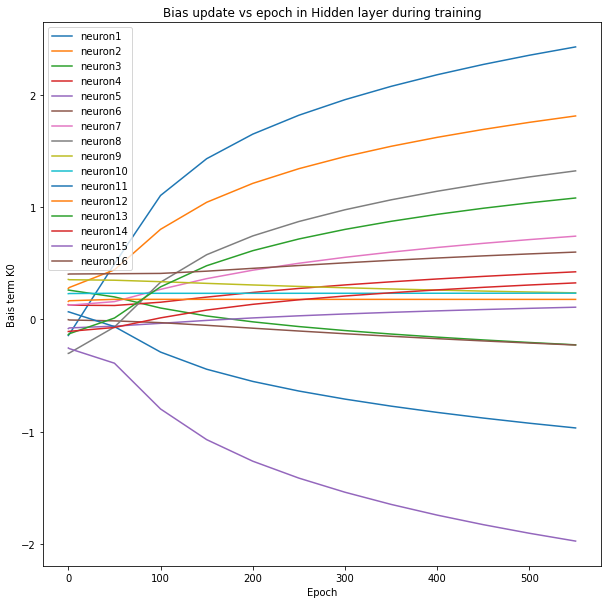

In [60]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,k0_hidden)
plt.title('Bias update vs epoch in Hidden layer during training')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5','neuron6','neuron7','neuron8','neuron9',\
            'neuron10','neuron11','neuron12','neuron13','neuron14','neuron15','neuron16'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Plotting Bias term(k0) of each neuron in output layer vs epoch

Text(0, 0.5, 'Bais term K0')

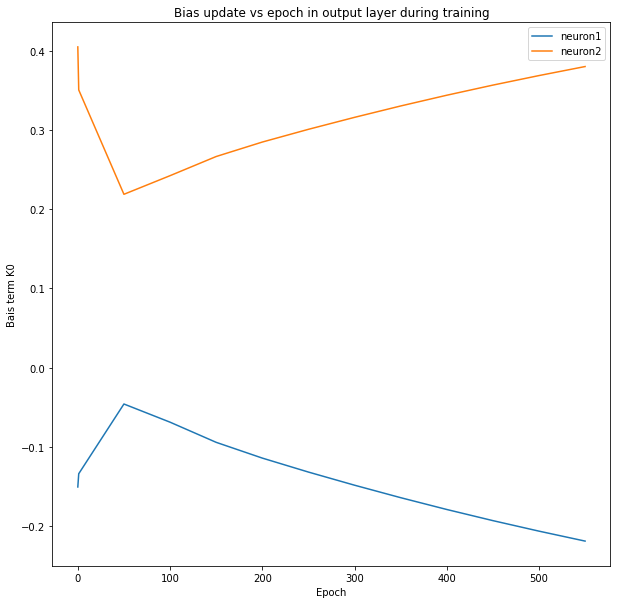

In [32]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,k0_output)
plt.title('Bias update vs epoch in output layer during training')
plt.legend(['neuron1', 'neuron2'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Relu Activation

In [33]:
# # evaluate algorithm using relu activation function using he_normal weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 16
af = 'relu'
relu_train_scores,relu_test_scores,relu_train_losses,relu_test_losses,relu_f1_scores,relu_k_scores,epochs,relu_ep_loss,relu_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.25530935301275093, 0.24380479511699868, 0.31648280402071266, 0.3645558356264151, 0.07619610722291922, -0.04997944558586592, 0.3164190464143971, 0.30929003238549907, 0.24532091820533267, -0.2877296507584589, 0.6538767796373568, -0.045628940537056725, 0.5128407832322994, 0.3852025347819064, 0.23588063252793035, -0.2525949426056567, -0.011396458094096956, -0.05728908712752297, 0.015932114679150525, -0.08169244778931788, 0.6560332129796247, 0.43678696019494423, 0.5196817195726855, 0.5099066952547787, 0.47378168645631275, 0.12494316503388014, 0.26338679956198474, 0.347813150198721, 0.5359804436492305, 0.2159378189545034, -1.2423224152353842], 'output': 0.23278284988814366, 'delta': -0.0013829255305092682}, {'weights': [0.03756041047262559, -0.05772235107928323, -0.10326859714285967, -0.03463920300729415, 0.3686500838053933, 0.41031707978848353, -0.12333696645907079, -0.12956681231922693, 0.25324521133757

In [34]:
print('Train Scores of relu activation function : %s' % relu_train_scores)
print('Mean Train Accuracy of relu activation function: %.3f%%' % (sum(relu_train_scores)/float(len(relu_train_scores))))
print('\n')
print('Test Scores of relu activation function: %s' % relu_test_scores)
print('Mean Test Accuracy of relu activation function: %.3f%%' % (sum(relu_test_scores)/float(len(relu_test_scores))))

Train Scores of relu activation function : [98.23008849557522, 98.45132743362832, 98.89380530973452, 98.45132743362832, 98.45132743362832]
Mean Train Accuracy of relu activation function: 98.496%


Test Scores of relu activation function: [97.34513274336283, 97.34513274336283, 97.34513274336283, 97.34513274336283, 96.46017699115043]
Mean Test Accuracy of relu activation function: 97.168%


In [35]:
print('Train Losses of relu activation function: %s' % relu_train_losses)
print('Mean Train loss of relu activation function: %.3f%%' % (sum(relu_train_losses)/float(len(relu_train_losses))))
print('\n')
print('Test Losses of relu activation function: %s' % relu_test_losses)
print('Mean Test loss of relu activation function: %.3f%%' % (sum(relu_test_losses)/float(len(relu_test_losses))))

Train Losses of relu activation function: [0.611305776901074, 0.5348925547884394, 0.38206611056317097, 0.5348925547884394, 0.5348925547884396]
Mean Train loss of relu activation function: 0.520%


Test Losses of relu activation function: [0.9169586653516109, 0.916958665351611, 0.9169586653516109, 0.9169586653516107, 1.2226115538021476]
Mean Test loss of relu activation function: 0.978%


In [36]:
for i in range(n_folds):
  print(f"\nF1 Score of relu activation for fold number-{i} is")
  print(relu_f1_scores[i])


F1 Score of relu activation for fold number-0 is
[0.9787234  0.96470588]

F1 Score of relu activation for fold number-1 is
[0.97841727 0.96551724]

F1 Score of relu activation for fold number-2 is
[0.97810219 0.96629213]

F1 Score of relu activation for fold number-3 is
[0.98089172 0.95652174]

F1 Score of relu activation for fold number-4 is
[0.97101449 0.95454545]


In [37]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(relu_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.943471735867934

 Çohen Kappa Score for fold number-1 is
0.9439762022806147

 Çohen Kappa Score for fold number-2 is
0.9444353384691034

 Çohen Kappa Score for fold number-3 is
0.9374654122855561

 Çohen Kappa Score for fold number-4 is
0.9256578947368421


In [38]:
relu_k0_hidden = relu_k0[0:][::2]
relu_k0_output = relu_k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for relu activation function with He Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

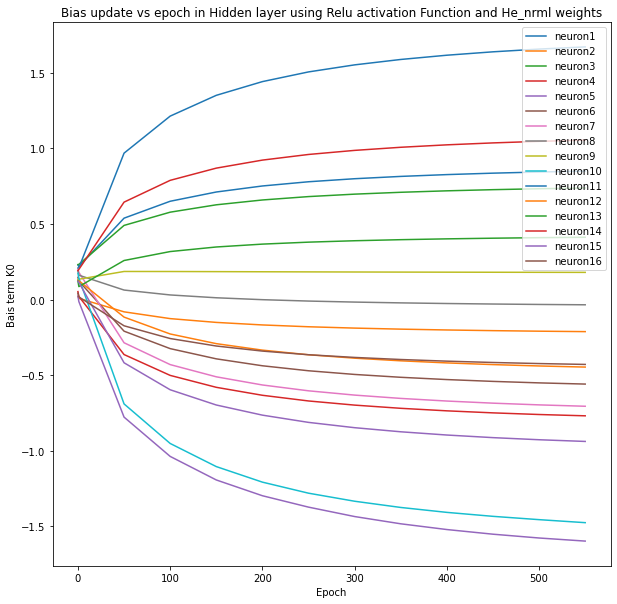

In [59]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,relu_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5','neuron6','neuron7','neuron8','neuron9',\
            'neuron10','neuron11','neuron12','neuron13','neuron14','neuron15','neuron16'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Output layer

Text(0, 0.5, 'Bais term K0')

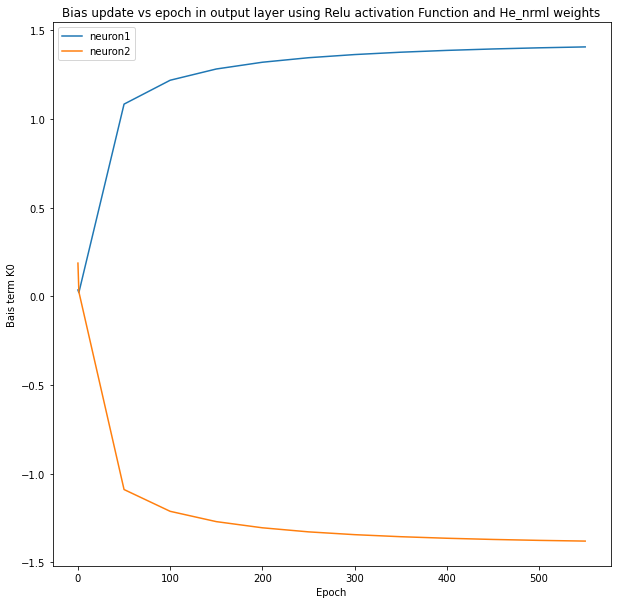

In [40]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,relu_k0_output)
plt.title('Bias update vs epoch in output layer using Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Tanh Activation Function

In [41]:
# # evaluate algorithm using sigmoid activation function using xavier glorot weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 16
af = 'tanh'
tanh_train_scores,tanh_test_scores,tanh_train_losses,tanh_test_losses,tanh_f1_scores,tanh_k_scores,epochs,tanh_ep_loss,tanh_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.6556569836658972, 0.20179116680634937, 0.5702844060799513, 0.4200858202165006, 0.06923430420126785, 0.3586188054286476, 0.15789480324439803, 0.6492261529412767, 0.8281557745294954, 0.055423001450315416, 0.8981337633729716, 0.1939973753560657, 0.6851049841957088, 0.09007335567649301, 0.6740923399372877, 0.11922165490632888, 0.7408831662244344, 0.43451995550899924, 0.957808427490691, 0.9742843324752017, 0.9440790086709501, 0.21111602531752008, 0.15227857744985343, 0.757298841720202, 0.38700596306709606, 0.3602054147884745, 0.5247566684331749, 0.7492615578785623, 0.7503413199944325, 0.6630122330383293, 0.15121443508685614], 'output': 0.9975475943469388, 'delta': -0.00011547876219934596}, {'weights': [0.00986776552156264, 0.7492859965984062, 0.901635880412055, 0.9044447671844179, 0.1963728407488981, 0.7875604597393533, 0.353427123396215, 0.3360858896229416, 0.5051520931195237, 0.5943353882255688, 0.6035

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


The weights, biases and output values at the end of training each fold
[[{'weights': [0.39614471539732365, 0.49978697495802327, 0.8871558245080079, 0.8580542418567529, 0.5568222225308067, 0.23536814815425625, 0.5977108921923922, 0.07500531408843389, 0.7626193374674721, 0.05632478116445443, 0.6903418465441966, 0.8531415237375478, 0.19708030655915484, 0.6978327760939677, 0.8780254435274946, 0.8231867549693229, 0.05434578212882653, 0.17859788798731885, 0.042759639304526975, 0.8346442963716506, 0.25558305111354795, 0.1909137039507435, 0.40779873404938366, 0.9637226313097085, 0.06487847165255858, 0.17958730300548556, 0.04509279573909722, 0.8247368228582419, 0.8490119472120452, 0.7178975518864688, 0.8137952546150952], 'output': 0.9992612085029411, 'delta': -2.6878404786172155e-08}, {'weights': [0.059090404960065034, 0.5542381663998146, 0.749250353768769, 0.32771749944804823, 0.8698129940531182, 0.6877872859653337, 0.9537467499209278, 0.7734597845148287, 0.0027747757809491415, 0.9635694690374

In [42]:
print('Train Scores of tanh activation function : %s' % tanh_train_scores)
print('Mean Train Accuracy of tanh activation function: %.3f%%' % (sum(tanh_train_scores)/float(len(tanh_train_scores))))
print('\n')
print('Test Scores of tanh activation function: %s' % relu_test_scores)
print('Mean Test Accuracy of tanh activation function: %.3f%%' % (sum(tanh_test_scores)/float(len(tanh_test_scores))))

Train Scores of tanh activation function : [35.39823008849557, 38.05309734513274, 97.78761061946902, 97.78761061946902, 98.67256637168141]
Mean Train Accuracy of tanh activation function: 73.540%


Test Scores of tanh activation function: [97.34513274336283, 97.34513274336283, 97.34513274336283, 97.34513274336283, 96.46017699115043]
Mean Test Accuracy of tanh activation function: 74.867%


In [43]:
print('Train Losses of tanh activation function: %s' % tanh_train_losses)
print('Mean Train loss of tanh activation function: %.3f%%' % (sum(tanh_train_losses)/float(len(tanh_train_losses))))
print('\n')
print('Test Losses of tanh activation function: %s' % tanh_test_losses)
print('Mean Test loss of tanh activation function: %.3f%%' % (sum(tanh_test_losses)/float(len(tanh_test_losses))))

Train Losses of tanh activation function: [22.31266085688936, 21.395702191537733, 0.7641322211263424, 0.7641322211263424, 0.4584793326758055]
Mean Train loss of tanh activation function: 9.139%


Test Losses of tanh activation function: [18.950479083933285, 22.618313745339726, 0.3056528884505363, 0.611305776901074, 0.9169586653516109]
Mean Test loss of tanh activation function: 8.681%


In [44]:
for i in range(n_folds):
  print(f"\nF1 Score of tanh activation for fold number-{i} is")
  print(tanh_f1_scores[i])


F1 Score of tanh activation for fold number-0 is
[       nan 0.62195122]

F1 Score of tanh activation for fold number-1 is
[       nan 0.51315789]

F1 Score of tanh activation for fold number-2 is
[0.99270073 0.98876404]

F1 Score of tanh activation for fold number-3 is
[0.98734177 0.97058824]

F1 Score of tanh activation for fold number-4 is
[0.97902098 0.96385542]


In [45]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(tanh_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.0

 Çohen Kappa Score for fold number-1 is
0.0

 Çohen Kappa Score for fold number-2 is
0.9814662948991307

 Çohen Kappa Score for fold number-3 is
0.957945664309639

 Çohen Kappa Score for fold number-4 is
0.9428812131423757


In [46]:
tanh_k0_hidden = tanh_k0[0:][::2]
tanh_k0_output = tanh_k0[1:][::2]

## Plotting Bias term(k0) of each neuron in hidden layer vs epoch for tanh activation function with random weight Intializer

Text(0, 0.5, 'Bais term K0')

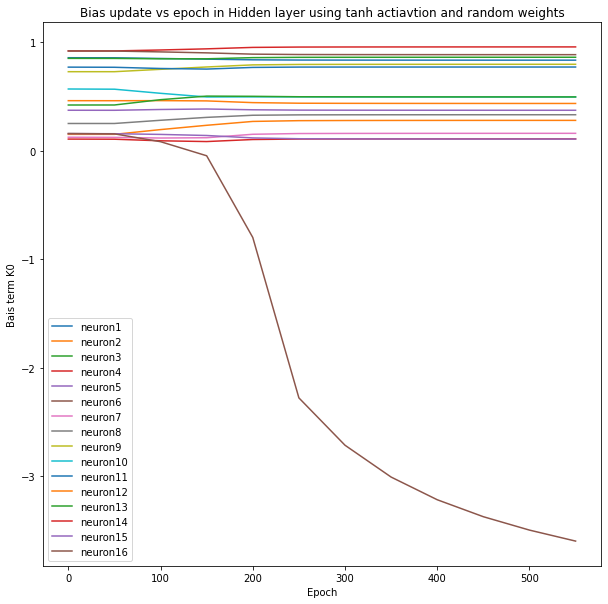

In [58]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,tanh_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using tanh actiavtion and random weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5','neuron6','neuron7','neuron8','neuron9',\
            'neuron10','neuron11','neuron12','neuron13','neuron14','neuron15','neuron16'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

### Output layer

Text(0, 0.5, 'Bais term K0')

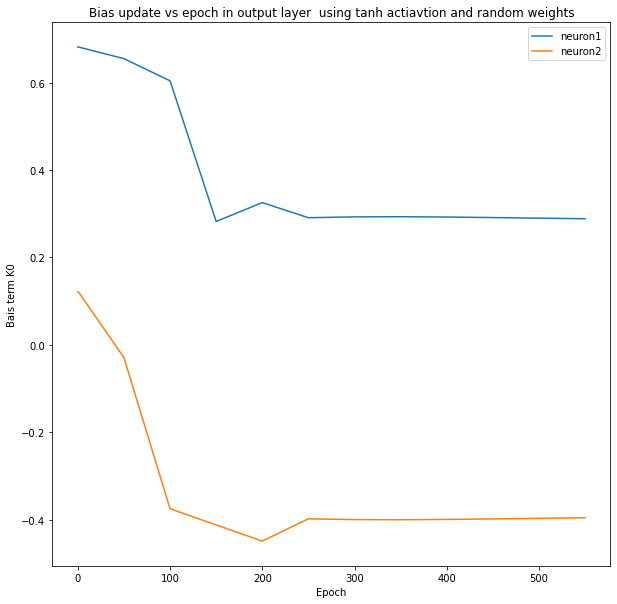

In [48]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,tanh_k0_output)
plt.title('Bias update vs epoch in output layer  using tanh actiavtion and random weights')
plt.legend(['neuron1', 'neuron2'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

## Leaky Relu

In [49]:
# evaluate algorithm using relu activation function using he_normal weight intialzier
n_folds = 5
l_rate = 0.005 
mu=0.001
n_epoch = 600
n_hidden = 16
af = 'leaky_relu'
lrelu_train_scores,lrelu_test_scores,lrelu_train_losses,lrelu_test_losses,lrelu_f1_scores,lrelu_k_scores,epochs,lrelu_ep_loss,lrelu_k0 = run_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden,af)

The weights, biases and output values at the end of training each fold
[[{'weights': [0.0863668197084808, 0.2352183110776252, 0.1586638380060523, 0.41281288331190724, 0.11842495611425241, -0.18945847468827504, 0.4574313245259053, 0.541896438557155, 0.15750918957459947, -0.3267685554265668, 0.46562533995308253, 0.004922064125210605, 0.16127456014363525, 0.3251160732222411, 0.4131738914018896, -0.24093202295586802, 0.07685239064444757, 0.07496800356856864, -0.06092783090386886, -0.18738325776833736, 0.6364086760718718, 0.5314679664032257, 0.37870994158548993, 0.6008644348363157, 0.5761759492383953, 0.05742298960939024, 0.16800913578945834, 0.45168410409633836, 0.6022243705139112, 0.23523939239397762, -1.2806305620331282], 'output': 0.09724892603098512, 'delta': -0.00014016775095914054}, {'weights': [0.00941687121561771, 0.12296818066737944, 0.00472762061975763, -0.010534109647772169, 0.12389250625175345, 0.1629270732694484, -0.11454770766326355, -0.16126009165947783, 0.07904884421321412,

In [50]:
print('Train Scores of leaky relu activation function : %s' % lrelu_train_scores)
print('Mean Train Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_train_scores)/float(len(lrelu_train_scores))))
print('\n')
print('Test Scores of leaky relu activation function: %s' % lrelu_test_scores)
print('Mean Test Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_test_scores)/float(len(lrelu_test_scores))))

Train Scores of leaky relu activation function : [99.11504424778761, 98.45132743362832, 98.89380530973452, 98.23008849557522, 98.67256637168141]
Mean Train Accuracy of leaky relu activation function: 98.673%


Test Scores of leaky relu activation function: [95.57522123893806, 99.11504424778761, 96.46017699115043, 99.11504424778761, 97.34513274336283]
Mean Test Accuracy of leaky relu activation function: 97.522%


In [51]:
print('Train Scores of leaky relu activation function : %s' % lrelu_train_scores)
print('Mean Train Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_train_scores)/float(len(lrelu_train_scores))))
print('\n')
print('Test Scores of leaky relu activation function: %s' % lrelu_test_scores)
print('Mean Test Accuracy of leaky relu activation function: %.3f%%' % (sum(lrelu_test_scores)/float(len(lrelu_test_scores))))

Train Scores of leaky relu activation function : [99.11504424778761, 98.45132743362832, 98.89380530973452, 98.23008849557522, 98.67256637168141]
Mean Train Accuracy of leaky relu activation function: 98.673%


Test Scores of leaky relu activation function: [95.57522123893806, 99.11504424778761, 96.46017699115043, 99.11504424778761, 97.34513274336283]
Mean Test Accuracy of leaky relu activation function: 97.522%


In [52]:
print('Train Losses of leaky relu activation function: %s' % lrelu_train_losses)
print('Mean Train loss of leaky relu activation function: %.3f%%' % (sum(lrelu_train_losses)/float(len(lrelu_train_losses))))
print('\n')
print('Test Losses of leaky relu activation function: %s' % lrelu_test_losses)
print('Mean Test loss of leaky relu activation function: %.3f%%' % (sum(lrelu_test_losses)/float(len(lrelu_test_losses))))

Train Losses of leaky relu activation function: [0.30565288845053673, 0.5348925547884398, 0.3820661105631713, 0.611305776901074, 0.45847933267580554]
Mean Train loss of leaky relu activation function: 0.458%


Test Losses of leaky relu activation function: [1.5282644422526852, 0.3056528884505361, 1.222611553802148, 0.30565288845053645, 0.9169586653516111]
Mean Test loss of leaky relu activation function: 0.856%


In [53]:
for i in range(n_folds):
  print(f"\nF1 Score of relu activation for fold number-{i} is")
  print(lrelu_f1_scores[i])


F1 Score of relu activation for fold number-0 is
[0.96644295 0.93506494]

F1 Score of relu activation for fold number-1 is
[0.99300699 0.98795181]

F1 Score of relu activation for fold number-2 is
[0.97142857 0.95348837]

F1 Score of relu activation for fold number-3 is
[0.99371069 0.98507463]

F1 Score of relu activation for fold number-4 is
[0.97637795 0.96969697]


In [54]:
for i in range(n_folds):
  print(f"\n Çohen Kappa Score for fold number-{i} is")
  print(lrelu_k_scores[i])


 Çohen Kappa Score for fold number-0 is
0.9015164720237058

 Çohen Kappa Score for fold number-1 is
0.9809604043807919

 Çohen Kappa Score for fold number-2 is
0.9249418797741614

 Çohen Kappa Score for fold number-3 is
0.9787873099305425

 Çohen Kappa Score for fold number-4 is
0.9461134954697187


In [55]:
lrelu_k0_hidden = lrelu_k0[0:][::2]
lrelu_k0_output = lrelu_k0[1:][::2]

### Plotting Bias term(k0) of each neuron in hidden layer vs epoch for leaky relu activation function with He Normal weight Intializer

Text(0, 0.5, 'Bais term K0')

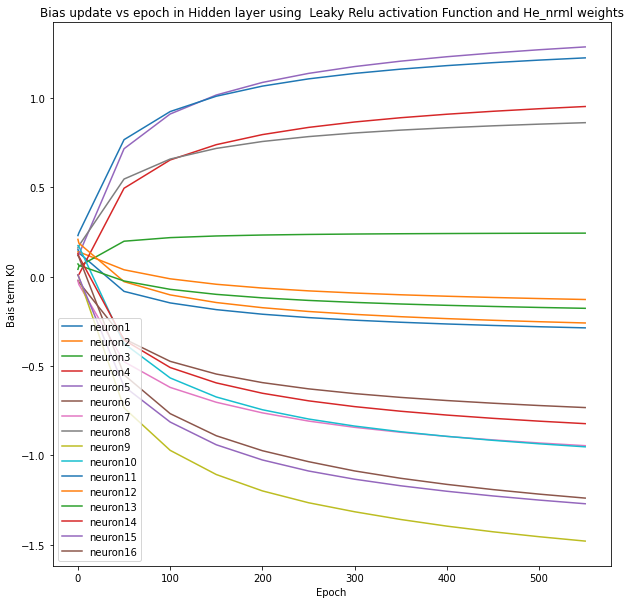

In [56]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,lrelu_k0_hidden)
plt.title('Bias update vs epoch in Hidden layer using  Leaky Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2', 'neuron3', 'neuron4', 'neuron5','neuron6','neuron7','neuron8','neuron9',\
            'neuron10','neuron11','neuron12','neuron13','neuron14','neuron15','neuron16'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

Text(0, 0.5, 'Bais term K0')

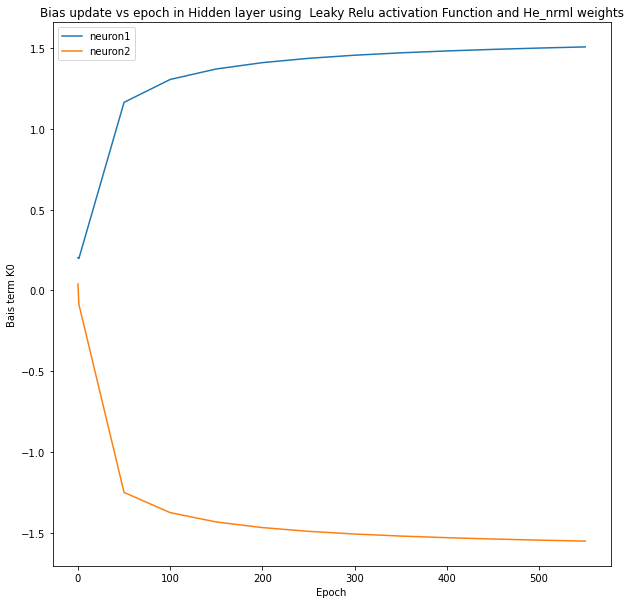

In [57]:
ep2 = list(epochs)
plt.figure(figsize=(10,10))
plt.plot(ep2,lrelu_k0_output)
plt.title('Bias update vs epoch in Hidden layer using  Leaky Relu activation Function and He_nrml weights')
plt.legend(['neuron1', 'neuron2'])
plt.xlabel("Epoch")
plt.ylabel("Bais term K0")

# Epoch Vs Loss Function

Text(0.5, 1.0, 'Activation Functions - Performance')

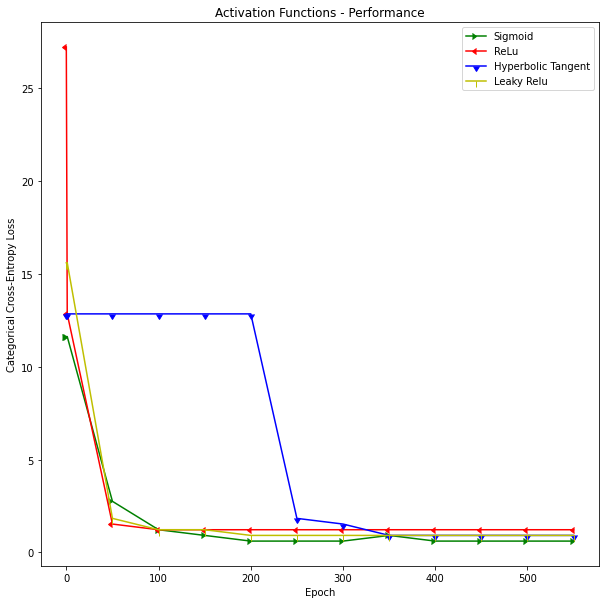

In [62]:
ep2 = list(epochs)
sigm = list(sig_ep_loss)
relu = list(relu_ep_loss)
lrelu = list(lrelu_ep_loss)
tanh = list(tanh_ep_loss)
plt.figure(figsize=(10,10))
l1 , = plt.plot(ep2, sigm, "m-",color='g',label="Sigmoid", marker=5)
l2 , = plt.plot(ep2, relu, "m-",color='r',label="ReLu", marker=8)
l3 , = plt.plot(ep2, tanh, "m-",color='b',label="Hyperbolic Tangent",marker=11)
l4 , = plt.plot(ep2, lrelu, "m-",color='y',label="Leaky Relu",marker=3)
plt.legend(handles=[l1,l2,l3,l4], loc=1)
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Activation Functions - Performance")